# Your first TStore

In this tutorial, we will build a TStore of observations from the meteorological stations operated by Agrometeo[<sup>1</sup>](#agrometeo) in the Canton of Vaud, Switzerland during the last 5 years. We will use the [meteora](https://github.com/martibosch/meteora) package to fetch the data.

In [ ]:
import os
import time
from datetime import datetime, timedelta
from os import path

import contextily as cx
import osmnx as ox
import pandas as pd
import tqdm
from meteora.clients import AgrometeoClient

import tstore


def get_tstore_filepaths(base_dir):
    return [
        path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames
    ]


def describe_tstore(base_dir, n_head_rows=5, n_tail_rows=5):
    tstore_filepaths = get_tstore_filepaths(base_dir)
    for line in (
        tstore_filepaths[:n_head_rows] + ["..."] + tstore_filepaths[-n_tail_rows:]
    ):
        print(line)
    total_size = sum(
        path.getsize(tstore_filepath) for tstore_filepath in tstore_filepaths
    )
    print(f"Total size: {total_size/1e6} MB (in {len(tstore_filepaths)} files)")

Let us first have a look at the stations' locations:

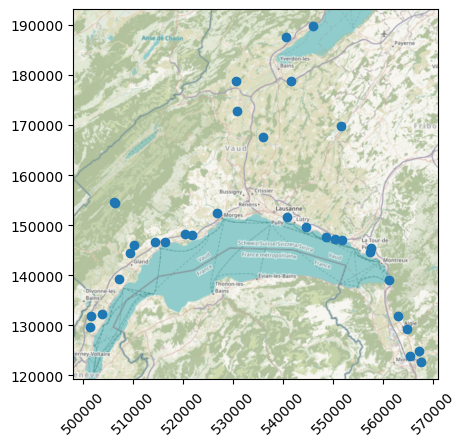

In [ ]:
region = "Canton de Vaud"

client = AgrometeoClient(region)

ax = client.stations_gdf.plot()
cx.add_basemap(ax=ax, crs=client.stations_gdf.crs, attribution="")
ax.tick_params(axis="x", labelrotation=45)
# ax.get_figure().savefig("")

Likewise many other APIs, Agrometeo limits the amount of data that can be fetched in a single request. Therefore, we will fetch the data in chunks of 1 month and concatenate it. Let's start by looking at 1-month chunk of data:

In [ ]:
variables = ["temperature", "water_vapour", "precipitation"]
start_date = "2021-01-01"
end_date = "2021-01-31"
client.get_ts_df(variables, start_date, end_date)

variable                 temperature  water_vapour  precipitation
id  date                                                         
1   2021-01-01 00:00:00          2.2          99.0            0.2
    2021-01-01 00:10:00          2.3          99.0            0.2
    2021-01-01 00:20:00          2.4          99.0            0.1
    2021-01-01 00:30:00          2.4          99.0            0.2
    2021-01-01 00:40:00          2.5          99.0            0.2
...                              ...           ...            ...
305 2021-01-31 23:10:00          7.0          80.0            0.0
    2021-01-31 23:20:00          7.1          78.0            0.1
    2021-01-31 23:30:00          6.9          80.0            0.0
    2021-01-31 23:40:00          6.9          81.0            0.0
    2021-01-31 23:50:00          6.8          82.0            0.2

[147312 rows x 3 columns]

Let us now iteratively assemble 5 years of data:

In [ ]:
num_years = 5
# https://pandas.pydata.org/docs/user_guide/timeseries.html#period-aliases
freq = "1MS"

yesterday = datetime.now().replace(
    hour=0,
    minute=0,
    second=0,
    microsecond=0,
) - timedelta(days=1)
date_range = pd.date_range(
    yesterday - timedelta(days=365 * num_years),
    yesterday,
    freq=freq,
)

long_ts_df = pd.concat(
    [
        client.get_ts_df(variables, start_date, end_date - timedelta(days=1))
        for start_date, end_date in tqdm.tqdm(
            zip(date_range[:-1], date_range[1:]),
            total=len(date_range) - 1,
        )
    ],
)
long_ts_df

100%|█████████████████████████████████████████████████| 59/59 [15:12<00:00, 15.46s/it]


variable                 temperature  water_vapour  precipitation
id  date                                                         
1   2019-11-01 00:00:00         10.1          99.0            0.0
    2019-11-01 00:10:00         10.1          99.0            0.0
    2019-11-01 00:20:00         10.1          99.0            0.0
    2019-11-01 00:30:00         10.2          99.0            0.0
    2019-11-01 00:40:00         10.1          99.0            0.0
...                              ...           ...            ...
305 2024-09-30 23:10:00         18.4          64.0            0.0
    2024-09-30 23:20:00         18.3          64.0            0.0
    2024-09-30 23:30:00         18.5          63.0            0.0
    2024-09-30 23:40:00         18.1          68.0            0.0
    2024-09-30 23:50:00         18.1          66.0            0.0

[8530041 rows x 3 columns]

We can now dump this data frame into a tstore:

In [ ]:
# basic tstore args
tstore_dir = "agrometeo-tstore"
tstore_structure = "id-var"
overwrite = True
id_var = "station"
time_var = "time"
partitioning = "year"
# static_variables = ["variable"]

# rename data frame columns
long_ts_df = long_ts_df.reset_index().rename(columns={"id": id_var, "date": time_var})

# prepare stations geo-data frame
stations_gdf = client.stations_gdf.rename_axis(
    index={client.stations_gdf.index.name: id_var},
)["geometry"].reset_index()
# ensure that we have the same dtype for the stations ids in the time series and stations data frames
stations_gdf[id_var] = stations_gdf[id_var].astype(long_ts_df[id_var].dtype)

# dump to tstore
# TODO: implement `to_tstore` method for wide dataframes too.
tslong = tstore.TSLong(
    long_ts_df,
    id_var,
    time_var=time_var,
    ts_vars=variables,
    geometry=stations_gdf,
)
start = time.time()
tslong.to_tstore(
    tstore_dir,
    partitioning=partitioning,
    tstore_structure=tstore_structure,
    overwrite=overwrite,
)
print(f"Dumped tstore in: {time.time() - start:.2f} s")

# show the tstore
describe_tstore(tstore_dir)

# read the tstore
start = time.time()
ts_df = tstore.open_tslong(tstore_dir, backend="pandas")
print(f"Read tstore in: {time.time() - start:.2f} s")

Dumped tstore in: 7.56 s
agrometeo-tstore/tstore_metadata.yaml
agrometeo-tstore/_attributes.parquet
agrometeo-tstore/96/temperature/_common_metadata
agrometeo-tstore/96/temperature/_metadata
agrometeo-tstore/96/temperature/year=2020/part-0.parquet
...
agrometeo-tstore/27/precipitation/year=2021/part-0.parquet
agrometeo-tstore/27/precipitation/year=2019/part-0.parquet
agrometeo-tstore/27/precipitation/year=2022/part-0.parquet
agrometeo-tstore/27/precipitation/year=2023/part-0.parquet
agrometeo-tstore/27/precipitation/year=2024/part-0.parquet
Total size: 250.054177 MB (in 794 files)
Read tstore in: 30.19 s


We can see that this creates a hierarchical structure in which for each station id, a folder is created for variable. Each variable folder is composed of metadata as well as the actual data partitioned by months (as specified with the `partitioning` argument). 

## Grouping (or not) variables

In the above example we have separated each variable by providing the `ts_vars` argument to the `to_tstore` method. However, it is also possible to group the variables (for each station) into a single (multivariate) time series, which in this example will result in larger parquet files that are more inefficient [<sup>2</sup>](#parquet-file-size):

In [ ]:
grouped_tstore_dir = "grouped-tstore"

# dump to tstore
start = time.time()
tstore.TSLong(
    long_ts_df,
    id_var,
    time_var=time_var,
    geometry=stations_gdf,
).to_tstore(
    grouped_tstore_dir,
    partitioning=partitioning,
    tstore_structure=tstore_structure,
    overwrite=overwrite,
)
print(f"Dumped tstore in: {time.time() - start:.2f} s")

# show the tstore
describe_tstore(grouped_tstore_dir)

start = time.time()
ts_df = tstore.open_tslong(grouped_tstore_dir, backend="pandas")
print(f"Read tstore in: {time.time() - start:.2f} s")

Dumped tstore in: 4.00 s
grouped-tstore/tstore_metadata.yaml
grouped-tstore/_attributes.parquet
grouped-tstore/96/ts_variable/_common_metadata
grouped-tstore/96/ts_variable/_metadata
grouped-tstore/96/ts_variable/year=2020/part-0.parquet
...
grouped-tstore/27/ts_variable/year=2021/part-0.parquet
grouped-tstore/27/ts_variable/year=2019/part-0.parquet
grouped-tstore/27/ts_variable/year=2022/part-0.parquet
grouped-tstore/27/ts_variable/year=2023/part-0.parquet
grouped-tstore/27/ts_variable/year=2024/part-0.parquet
Total size: 94.873459 MB (in 266 files)
Read tstore in: 3.83 s


We can see that for each station, all the variables have been grouped into a single `ts_variable` folder, whose parquet files are now multivariate time series data frames.

Note that in this case grouping variables is much more efficient both in terms of read/write times and total disk size. Nevertheless, for the ilustrative purposes of this tutorial, the reminder of the notebook will consider the tstore with the separated variables.



## Filtering at read time

Note that we may be interested in reading a single variable, in which case reading times are dramatically reduced:

In [ ]:
start = time.time()
variable = "temperature"
T_ts_df = tstore.open_tslong(tstore_dir, ts_variables=variable, backend="pandas")
print(f"Read tstore for {variable} in: {time.time() - start:.2f} s")
T_ts_df

Read tstore for temperature in: 2.70 s


,station,temperature,time
0,78,6.8,2019-11-01 00:00:00
1,78,6.8,2019-11-01 00:10:00
2,78,6.7,2019-11-01 00:20:00
3,78,6.5,2019-11-01 00:30:00
4,78,6.5,2019-11-01 00:40:00
...,...,...,...
8530036,27,5.4,2022-04-29 04:20:00
8530037,27,5.3,2022-04-29 04:30:00
8530038,27,5.0,2022-04-29 04:40:00
8530039,27,5.0,2022-04-29 04:50:00


We may only be interested in loading a specific subset of the data, e.g., time period:

In [ ]:
start = time.time()
ts_2021_df = tstore.open_tslong(
    tstore_dir,
    start_time="2021-01-01",
    end_time="2021-12-31",
    inclusive="both",
    backend="pandas",
)
print(f"Read tstore for one year in: {time.time() - start:.2f} s")

Read tstore for one year in: 6.01 s


which can result in important performance gains as filters are applied at read time. We can further filter the time range and target variables simoultaneously:

In [ ]:
start = time.time()
variable = "temperature"
T_ts_2021_df = tstore.open_tslong(
    tstore_dir,
    ts_variables=variable,
    start_time="2021-01-01",
    end_time="2021-12-31",
    backend="pandas",
)
print(f"Read tstore for one variable, one year in: {time.time() - start:.2f} s")

Read tstore for one variable, one year in: 2.22 s


## Using different backends

Note that in all the above examples the data has been loaded into a pandas data frame. However, since tstore is based on the PyArrow data model, we may also zero-copy read it into a different backend, e.g., polars:

In [ ]:
start = time.time()
variable = "temperature"
ts_pl_df = tstore.open_tslong(tstore_dir, backend="polars", ts_variables=variable)
print(
    f"Read tstore for one variable into polars data frame in: {time.time() - start:.2f} s",
)
ts_pl_df

Read tstore for one variable into polars data frame in: 2.11 s


station,temperature,time
str,f64,datetime[ns]
"""78""",20.6,2020-08-15 13:10:00
"""78""",20.8,2020-08-15 13:20:00
"""78""",19.8,2020-08-15 13:30:00
"""78""",19.6,2020-08-15 13:40:00
"""78""",19.8,2020-08-15 13:50:00
…,…,…
"""97""",24.2,2020-08-15 12:20:00
"""97""",24.4,2020-08-15 12:30:00
"""97""",24.7,2020-08-15 12:40:00


## TSDF: the (geo) time series data frame

In order offer better flexibility and control of which data is loaded into memory and when, we can also lazily read the whole TStore into a `TSDF` object:

In [ ]:
tsdf = tstore.open_tsdf(tstore_dir)
tsdf.head()

,station,temperature,water_vapour,precipitation,geometry
0,1,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (521720 148080)
1,3,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (507130 139310)
2,4,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (520355 148210)
3,10,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (557241 144716)
4,13,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (540810 151565)


Since we provided the geographic location of the stations when writing the TStore, the `TSDF` object will be based on geopandas, with a geometry column that allows performing geographic operations:

In [ ]:
district_geom = (
    ox.geocode_to_gdf("District de Lavaux-Oron").to_crs(tsdf.crs)["geometry"].iloc[0]
)
tsdf[tsdf["geometry"].within(district_geom)]

,station,temperature,water_vapour,precipitation,geometry
4,13,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (540810 151565)
11,41,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (548470 147690)
29,98,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (544528 149600)
32,305,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,Dask DataFrame Structure: ...,POINT (550365 147190)


and use the `TS._obj.compute()` method after selecting the target data, so that only the required files are read:

In [ ]:
tsdf.set_index("station").loc[0, "temperature"]._obj.compute()

variable,temperature
time,
2019-11-01 00:00:00,10.1
2019-11-01 00:10:00,10.1
2019-11-01 00:20:00,10.1
2019-11-01 00:30:00,10.2
2019-11-01 00:40:00,10.1
...,...
2024-09-30 23:10:00,15.4
2024-09-30 23:20:00,15.4
2024-09-30 23:30:00,15.3


###### TODO: better interface to lazily reading tsdf data

## Footnotes

1. <span id="agrometeo"></span> Data from [Agrometeo](https://www.agrometeo.ch/) belongs to the Swiss Federal Administration, see [the terms and conditions](https://www.admin.ch/gov/en/start/terms-and-conditions.html) for more information.
2. <span id="parquet-file-size"></span> Individual parquet files should be at least of a few houndred MBs in size. See the ["Parquet file format – everything you need to know!" blog post](https://data-mozart.com/parquet-file-format-everything-you-need-to-know) for more details.